In [34]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [84]:
class Value:

  def __init__(self, data, _children=(), _op="", label="") -> None:
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self) -> str:
    return f"Value(data={self.data})"

  def check_instance(self, other):
    return other if isinstance(other, Value) else Value(other)

  def __add__(self, other):
    other = self.check_instance(other)
    out = Value(self.data + other.data, (self, other), "+")

    def backward():
      # why "+=" instead of "="?
      # coz when a variable is used more than once, it overwrites the gradients
      # multivariate chain rule says we should just accumulate these variables
      # hence "+=" instead of "="
      self.grad += out.grad
      other.grad += out.grad

    out._backward = backward
    return out

  def __radd__(self, other):
    return self + other

  def __mul__(self, other):
    other = self.check_instance(other)
    out = Value(self.data * other.data, (self, other), "*")

    def backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = backward
    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "Only supports int/float values"
    out = Value(self.data ** other, (self, ), f"^{other}")

    def backward():
      self.grad += other * (self.data ** (other - 1)) * out.grad

    out._backward = backward
    return out

  def __truediv__(self, other): # self / other
    return self * other ** -1

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def tanh(self):
    n = self.data
    tan = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
    out = Value(tan, (self, ), "tan")

    def backward():
      self.grad += (1 - tan**2) * out.grad

    out._backward = backward
    return out

  def exp(self):
    x = self.data
    exp = math.exp(x)
    out = Value(exp, (self, ), "exp")

    def backward():
      self.grad += exp * out.grad

    out._backward = backward
    return out

  def backward(self):
    topo = []
    visit = set()
    def topo_sort(node):
      if node not in visit:
        visit.add(node)
        for child in node._prev:
          topo_sort(child)
        topo.append(node)
    topo_sort(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


In [85]:
a = Value(8.0)
b = Value(14.0)
a / b
a - b

Value(data=-6.0)

In [86]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})

  nodes, edges = trace(root)
  for node in nodes:
    uid = str(id(node))
    dot.node(name=uid, label="{%s|data %.4f|grad %.4f}"%(node.label, node.data, node.grad), shape="record")
    if node._op:
      dot.node(name=uid+node._op, label=node._op)
      dot.edge(uid + node._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

![broski](https://cs231n.github.io/assets/nn1/neuron_model.jpeg)

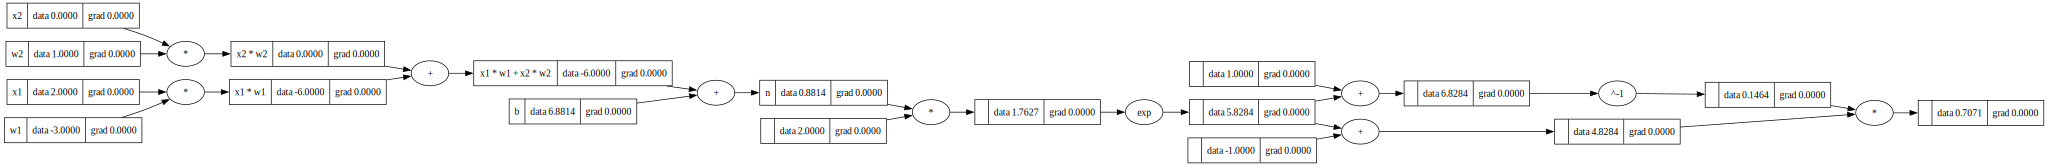

In [87]:
# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of the neuron
b = Value(6.8813735870195432, label="b")

x1w1 =  x1 * w1; x1w1.label = "x1 * w1"
x2w2 =  x2 * w2; x2w2.label = "x2 * w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1 * w1 + x2 * w2"
n = x1w1x2w2 + b; n.label = "n"

# activation function
# o = n.tanh(); o.label = "o"
e = (2*n).exp()
o = (e - 1)/(e + 1)
draw_dot(o)

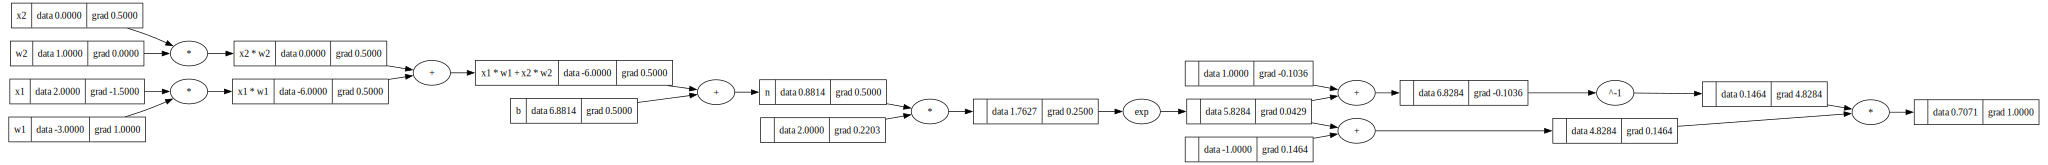

In [88]:
o.grad = 1
o.backward()
draw_dot(o)

In [89]:
import torch

In [90]:
x1 = torch.Tensor([2.0]).double()
x2 = torch.Tensor([0.0]).double()
w1 = torch.Tensor([-3.0]).double()
w2 = torch.Tensor([1.0]).double()
b = torch.Tensor([6.8813735870195432]).double()

x1.requires_grad = True
x2.requires_grad = True
w1.requires_grad = True
w2.requires_grad = True
b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
# print(o.data)

o.backward()

print("x2", x2.grad.item())
print("w2", w2.grad.item())
print("w1", w1.grad.item())
print("x1", x1.grad.item())


0.7071066904050358
x2 0.5000001283844369
w2 0.0
w1 1.0000002567688737
x1 -1.5000003851533106


In [140]:
import random
from typing import List

class Neuron:
  def __init__(self, nin: float):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x: List[float]):
    # w * x + b
    act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    params = [self.b] + self.w
    return params

class Layer:
  def __init__(self, nin: float, nout: float):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x: List[float]):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  def __init__(self, nin: float, nouts: List[float]):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

  def __call__(self, x: List[float]):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1]) # (number of neurons as input, [4-layer neuron, 4-layer neuron, final neutron output])
n(x)

Value(data=-0.09228834993061709)

In [141]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0]
] # input
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
ypred

[Value(data=-0.09228834993061709),
 Value(data=-0.33874934936335227),
 Value(data=0.2947864380830563),
 Value(data=0.3817438987619232)]

In [144]:
# trainingzzz
for k in range(500):
  # forward pass
  ypred = [n(x) for x in xs]

  # loss calculation
  loss = sum((yout - ygroundtruth)**2 for yout, ygroundtruth in zip(ypred, ys))

  # backward pass; reset grad to zero
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # nudge updates
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, "  ", loss.data)


0    0.027084451897102
1    0.024532614321290912
2    0.02240847578602936
3    0.020613948253589226
4    0.019078634721484716
5    0.01775073688608322
6    0.016591315838981494
7    0.015570549254121241
8    0.014665220651913249
9    0.013856993023102792
10    0.013131195603484556
11    0.012475954572443743
12    0.011881559271195977
13    0.011339992849905988
14    0.01084457972891864
15    0.010389717369151629
16    0.009970669773996512
17    0.009583406790678987
18    0.009224477804549571
19    0.008890911550317387
20    0.008580135961336409
21    0.008289913540761404
22    0.008018288863731694
23    0.007763545639495332
24    0.007524171365979899
25    0.007298828058215427
26    0.00708632786901715
27    0.006885612675565951
28    0.006695736900432795
29    0.006515852985599041
30    0.00634519905432592
31    0.006183088386523768
32    0.006028900404627575
33    0.005882072923411725
34    0.0057420954620639435
35    0.00560850345274717
36    0.005480873208757587
37    0.00535881753

In [145]:
ypred

[Value(data=0.9885480039279176),
 Value(data=-0.9931503978720554),
 Value(data=-0.9877475966683533),
 Value(data=0.9888515106129493)]

## Notes
- Gradient vector is _in_ the direction of loss, we need to go in the opposite direction of this to minimize loss, hence the negative sign when we update the data